<a href="https://colab.research.google.com/github/afoster145/iphs290_cultural_analytics_lda_topic_modeling/blob/main/Copy_of_network_tweets_similarity_20221130_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing text similarity using spaCy, networkX 

This notebook demonstrates one way of using spaCy to conduct a rapid thematic analysis of a small corpus of comments, and introduces some unusual network visualisations.
Topics include: 
* [spaCy](https://spacy.io/) - an open source NLP library, 
* word vectors, and
* networkX - an open source network (graph) analysis and visualisation library. 

The notebook is partly a reminder for myself on just how (well) these techniques work, but I hope that others find it useful. I'll continue to update it with more techniques over the coming weeks.
If you have any suggestions, feel free to make them in the comments, fork the notebook etc. I'm keen to exchange tips and tricks.

Edited/Expanded:

* 30 Nov 2022 by Jon Chun


# Plan

* load a representative set of tweets
* demonstrate some basic spaCy features
* test its similarity metrics
* build a graph data structure for storing (n * n-1) / 2 similarity results
* visualise the clusters of most-similar items in the data
* plan the next steps

In [ ]:
%whos

Variable           Type                          Data/Info
----------------------------------------------------------
InteractiveShell   MetaHasTraits                 <class 'IPython.core.inte<...>eshell.InteractiveShell'>
col_to_parse       str                           Tweet
count              int                           682
data               DataFrame                     Empty DataFrame\nColumns:<...>n\n[992 rows x 0 columns]
datetime           module                        <module 'datetime' from '<...>b/python3.8/datetime.py'>
doc                Doc                           'sorry but some people ne<...>epulsive music taste 😍😍😍'
eattr              dict                          n=1
edges_to_kill      list                          n=952446
end_date           date                          2022-12-02
equilibrium        float                         0.38291979053374176
extracted_tweets   str                           snscrape --format '{conte<...>2' > extracted-tweets.txt
from_date

In [ ]:
!pip install -U networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q snscrape==0.3.4

In [ ]:
# !pip install -U tweepy

In [ ]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
# from networkx.algorithms import community   # not used, yet... 
import datetime                              # access to %%time, for timing individual notebook cells
import os
from tqdm import tqdm

In [ ]:
print(nx.__version__)

2.8.8


This next step load the spaCy language model. It generally takes about 13s to load this 'large' model.

In [ ]:
import spacy.cli

spacy.cli.download("en_core_web_lg")

nlp = spacy.load('en_core_web_lg')           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally 
#nlp = spacy.load('en_core_web_md')           # a smaller model, e.g. for testing

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]  # makes the output plots large enough to be useful

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data

### snscrape (not Auth)

In [ ]:
# CUSTOMIZE: Define your search term

search_term = 'spotify wrapped'
from_date = '2020-10-01'

max_results = 1000

# set default ending date as today
today = datetime.date.today()
end_date = today

In [ ]:
%%time

# NOTE:

extracted_tweets = "snscrape --format '{content!r}'"+ f" --max-results {max_results} --since {from_date} twitter-search '{search_term} until:{end_date}' > extracted-tweets.txt"
os.system(extracted_tweets)
if os.stat("extracted-tweets.txt").st_size == 0:
  print('No Tweets found')
else:
  data = pd.read_csv('extracted-tweets.txt', names=['Tweet'])
  for row in data['Tweet'].iteritems():
    print(row)

("'I will forever take organic growth over inorganic growth\\n\\n@tisblvckoreo i celebrate your 19k+ streams for 2022 on #SpotifyWrapped\\n\\n2023 WE SHALL DO MORE", " WAY MUCH MORE!!!'")
("'my only goal for next year’s spotify wrapped is to be more consistent in my top artists. i want to listen to more music by the same artists and listen to whole albums instead of only listening the songs in my playlists'", nan)
("'Thanks @eltonofficial for spending 1", "794 minutes with me in 2022. I couldn’t stop listening to Cold Heart - PNAU Remix. #SpotifyWrapped https://t.co/XfQ8WzAS04'")
("'Thanks Ramin Djawadi for spending 2", "699 minutes with me in 2022. I couldn’t stop listening to The Green Dress. #SpotifyWrapped https://t.co/HscWZ37vMC'")
("'i have never heard of noah kahan he’s on everyone’s spotify wrapped how am i this far out of the loop'", nan)
("'Thanks @xxxtentacion for spending 3", "196 minutes with me in 2022. I couldn’t stop listening to what are you so afraid of. #SpotifyWrapp

In [ ]:
data.head()

,Tweet
'I will forever take organic growth over inorganic growth\n\n@tisblvckoreo i celebrate your 19k+ streams for 2022 on #SpotifyWrapped\n\n2023 WE SHALL DO MORE,WAY MUCH MORE!!!'
'my only goal for next year’s spotify wrapped is to be more consistent in my top artists. i want to listen to more music by the same artists and listen to whole albums instead of only listening the songs in my playlists',NaN
'Thanks @eltonofficial for spending 1,794 minutes with me in 2022. I couldn’t stop l...
'Thanks Ramin Djawadi for spending 2,699 minutes with me in 2022. I couldn’t stop l...
'i have never heard of noah kahan he’s on everyone’s spotify wrapped how am i this far out of the loop',NaN


In [ ]:
# Uncomment and run IF NECESSARY 
#   You MUST have a DataFrame column 'Tweet' that has the original text of each tweet
#   all other columns in the DataFrame are ignored from this point forward


data.drop(columns=['Tweet'], inplace=True)
data['Tweet'] = data.index

data.reset_index(inplace=True)

data.head()


,index,Tweet
0,'I will forever take organic growth over inorg...,'I will forever take organic growth over inorg...
1,'my only goal for next year’s spotify wrapped ...,'my only goal for next year’s spotify wrapped ...
2,'Thanks @eltonofficial for spending 1,'Thanks @eltonofficial for spending 1
3,'Thanks Ramin Djawadi for spending 2,'Thanks Ramin Djawadi for spending 2
4,'i have never heard of noah kahan he’s on ever...,'i have never heard of noah kahan he’s on ever...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   1000 non-null   object
 1   Tweet   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


### tweepy (Auth v1)

# SKIP unless you need expanded functionality of Twitter API via Tweepy

Create a file called 'config_twitter.py' based on the template below

```
API_KEY = ''
API_KEY_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''
```

1. Cut and paste the code above into a new plain text file called 'config_twitter.py'
2. Fill in the string values within ''s above
3. Save and upload to this Jupyter notebook temp filesystem

In [ ]:
"""
import tweepy
import config_twitter

consumer_key = config_twitter.API_KEY #Your API/Consumer key 
consumer_secret = config_twitter.API_KEY_SECRET #Your API/Consumer Secret Key
access_token = config_twitter.ACCESS_TOKEN    #Your Access token key
access_token_secret = config_twitter.ACCESS_TOKEN_SECRET #Your Access token Secret key
"""

In [ ]:
"""
#Pass in our twitter API authentication key
auth = tweepy.OAuth1UserHandler(
    consumer_key, consumer_secret,
    access_token, access_token_secret
)

#Instantiate the tweepy API
api = tweepy.API(auth, wait_on_rate_limit=True)
"""

In [ ]:
"""
# DEFINE YOUR SEARCH TERM 
search_query = "worldcup"

tweets_df = pd.DataFrame() 

try:
    #The number of tweets we want to retrieved from the search
    tweets = api.search_tweets(q=search_query, count=500)
    
    #Pulling Some attributes from the tweet
    attributes_container = [[tweet.user.name, tweet.created_at, tweet.favorite_count, tweet.source,  tweet.text] for tweet in tweets]

    #Creation of column list to rename the columns in the dataframe
    columns = ["User", "Date Created", "Number of Likes", "Source of Tweet", "Tweet"]
    
    #Creation of Dataframe
    tweets_df = pd.DataFrame(attributes_container, columns=columns)
except BaseException as e:
    print('Status Failed On,',str(e))
"""

In [ ]:
"""
data = tweets_df.copy(deep=True)
data.head()
data.info()
"""

,User,Date Created,Number of Likes,Source of Tweet,Tweet
0,Radicci,2022-11-30 15:52:59+00:00,0,Twitter for iPhone,"Tá liberado, mas tem que ser em todo e qualque..."
1,مادام بواری,2022-11-30 15:52:57+00:00,0,Twitter for Android,RT @SamanArbabi: #Qatar2022 #WorldCup #USAvIRN...
2,つつみ,2022-11-30 15:52:57+00:00,0,Twitter for iPhone,RT @aika_pokesuki: URスペシャルアートな世界。\nこれが神か...😇\n...
3,ᴄʜᴀᴍᴀʏ🇩🇰🇰🇷🏴󠁧󠁢󠁷󠁬󠁳󠁿💪🏻,2022-11-30 15:52:56+00:00,0,Twitter for iPad,RT @dbulandshold: På trods af godt dansk spil ...
4,Proof,2022-11-30 15:52:53+00:00,0,Twitter for Android,RT @Zakaria_Z_Army: From the mouth of the litt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   User             94 non-null     object             
 1   Date Created     94 non-null     datetime64[ns, UTC]
 2   Number of Likes  94 non-null     int64              
 3   Source of Tweet  94 non-null     object             
 4   Tweet            94 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 3.8+ KB


In [ ]:
# rowlimit = 500              # this limits the tweets to a manageable number
# data = pd.read_csv('../input/ExtractedTweets.csv', nrows = rowlimit)
# data.shape

In [ ]:
# data.head(6)

## Using spaCy to parse the tweets.

N.B. this next step can take a while - e.g. 14 mins, for the full set - but only 5s for 500 rows.

(based on https://stackoverflow.com/questions/44395656/applying-spacy-parser-to-pandas-dataframe-w-multiprocessing)...

In [ ]:
%%time

# NOTE:

tokens = []
lemma = []
pos = []
parsed_doc = [] 
col_to_parse = 'Tweet'

for doc in nlp.pipe(data[col_to_parse].astype('unicode').values, batch_size=50): # , n_threads=3):
  # if doc.is_parsed:
  if doc.has_annotation("DEP"):
    parsed_doc.append(doc)
    tokens.append([n.text for n in doc])
    lemma.append([n.lemma_ for n in doc])
    pos.append([n.pos_ for n in doc])
  else:
    # We want to make sure that the lists of parsed results have the
    # same number of entries of the original Dataframe, so add some blanks in case the parse fails
    tokens.append(None)
    lemma.append(None)
    pos.append(None)


data['parsed_doc'] = parsed_doc
data['comment_tokens'] = tokens
data['comment_lemma'] = lemma
data['pos_pos'] = pos

CPU times: user 3.51 s, sys: 68.5 ms, total: 3.58 s
Wall time: 3.61 s


In [ ]:
# Insert a unique id as identifier
# TODO: adjust scrape to capture TweetID as unique identifier

data.insert(0, 'SeqNo',range(0, len(data)))

## Basic checks of the parsed data

In [ ]:
data.head(8)

,SeqNo,index,Tweet,parsed_doc,comment_tokens,comment_lemma,pos_pos
0,0,'I will forever take organic growth over inorg...,'I will forever take organic growth over inorg...,"(', I, will, forever, take, organic, growth, o...","[', I, will, forever, take, organic, growth, o...","[', I, will, forever, take, organic, growth, o...","[PUNCT, PRON, AUX, ADV, VERB, ADJ, NOUN, ADP, ..."
1,1,'my only goal for next year’s spotify wrapped ...,'my only goal for next year’s spotify wrapped ...,"(', my, only, goal, for, next, year, ’s, spoti...","[', my, only, goal, for, next, year, ’s, spoti...","[', my, only, goal, for, next, year, ’s, spoti...","[PUNCT, PRON, ADJ, NOUN, ADP, ADJ, NOUN, PART,..."
2,2,'Thanks @eltonofficial for spending 1,'Thanks @eltonofficial for spending 1,"(', Thanks, @eltonofficial, for, spending, 1)","[', Thanks, @eltonofficial, for, spending, 1]","[', thank, @eltonofficial, for, spend, 1]","[PUNCT, NOUN, ADJ, ADP, VERB, NUM]"
3,3,'Thanks Ramin Djawadi for spending 2,'Thanks Ramin Djawadi for spending 2,"(', Thanks, Ramin, Djawadi, for, spending, 2)","[', Thanks, Ramin, Djawadi, for, spending, 2]","[', thanks, Ramin, Djawadi, for, spend, 2]","[PUNCT, INTJ, PROPN, PROPN, ADP, VERB, NUM]"
4,4,'i have never heard of noah kahan he’s on ever...,'i have never heard of noah kahan he’s on ever...,"(', i, have, never, heard, of, noah, kahan, he...","[', i, have, never, heard, of, noah, kahan, he...","[', I, have, never, hear, of, noah, kahan, he,...","[PUNCT, PRON, AUX, ADV, VERB, ADP, PROPN, PROP..."
5,5,'Thanks @xxxtentacion for spending 3,'Thanks @xxxtentacion for spending 3,"(', Thanks, @xxxtentacion, for, spending, 3)","[', Thanks, @xxxtentacion, for, spending, 3]","[', thank, @xxxtentacion, for, spend, 3]","[PUNCT, NOUN, NOUN, ADP, VERB, NUM]"
6,6,'Thanks LSDREAM for spending 1,'Thanks LSDREAM for spending 1,"(', Thanks, LSDREAM, for, spending, 1)","[', Thanks, LSDREAM, for, spending, 1]","[', thank, LSDREAM, for, spend, 1]","[PUNCT, NOUN, PROPN, ADP, VERB, NUM]"
7,7,Grazie Tiziano Ferro per i 629 minuti trascors...,Grazie Tiziano Ferro per i 629 minuti trascors...,"(Grazie, Tiziano, Ferro, per, i, 629, minuti, ...","[Grazie, Tiziano, Ferro, per, i, 629, minuti, ...","[Grazie, Tiziano, Ferro, per, i, 629, minuti, ...","[PROPN, PROPN, PROPN, ADP, NOUN, NUM, NOUN, NO..."


In [ ]:
data.Tweet[0]

"'I will forever take organic growth over inorganic growth\\n\\n@tisblvckoreo i celebrate your 19k+ streams for 2022 on #SpotifyWrapped\\n\\n2023 WE SHALL DO MORE"

In [ ]:
data.Tweet[1]

"'my only goal for next year’s spotify wrapped is to be more consistent in my top artists. i want to listen to more music by the same artists and listen to whole albums instead of only listening the songs in my playlists'"

In [ ]:
data.Tweet[10]

"'My top artist of 2022. Who was yours? #SpotifyWrapped  https://t.co/DH8VO2wRJ9'"

## Removing stopwords

We could reduce increase the signal:noise ratio in these texts by removing some of the more common words (or *stopwords*). By removing these from the tweets, we would prevent them from influencing the analysis of whether two tweets are similar. I'm not addressing this is the notebook yet, but I will come back to it later. For now, let's just look at what words are included in spaCy's stopword list.

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stopwords: %d' % len(stop_words))
print(list(stop_words))

Number of stopwords: 326
['these', 'only', 'by', 'itself', 'wherein', 'indeed', 'under', '‘m', 'alone', 'anyhow', 'himself', 'should', 'thru', 'sometime', 'see', "'ve", 'sixty', 'among', 'been', 'everyone', 'seemed', 'move', 'mostly', 'towards', 'besides', 'never', 'put', 'does', 'formerly', 'at', 'when', 'on', 'seem', 'whence', '‘re', 'me', 'regarding', 'over', 'go', 'whither', 'as', 'might', 'anywhere', 'other', 'how', 'each', 'beside', 'being', 'bottom', 'must', 'often', "'m", 'yourself', 'nowhere', 'therein', 'up', 'well', 'could', 'nothing', 'give', 'keep', 'show', 'somehow', 'did', '‘d', 'using', 'no', 'about', 'just', 'others', 'doing', 'hence', 'it', 'although', 'before', 'every', 'onto', 'hereupon', 'of', 'nevertheless', 'where', 'do', 'please', 'the', 'still', 'because', 'amount', 'none', 'neither', 'ca', 'seems', '’s', 'least', 'themselves', 'around', 'now', 'not', 'than', 'anyone', 'fifteen', 'unless', 'ours', 'which', 'noone', '’m', 'empty', 'have', 'his', 'various', 'n’t'

## Testing spaCy's similarity function

In [ ]:
print(data['parsed_doc'][0].similarity(data['parsed_doc'][1]))
print(data['parsed_doc'][0].similarity(data['parsed_doc'][10]))
print(data['parsed_doc'][1].similarity(data['parsed_doc'][10]))

0.6982158451547918
0.4367710966741572
0.48970702235903857


In [ ]:
# Hack so don't have to rename main DataFrame if following code (from another source)

world_data = data
#world_data = data[data.Party == 'Democrat']      # or use either of these, if you want to see tweets from only one party
#world_data = data[data.Party == 'Republican']

If you've limited the rows imported, then you may only have Democrat tweets (which occur first in the list).

In [ ]:
# data.Party.unique()

In [ ]:
# Create a fully-connected raw graph (raw_G) 
#   n node with n*(n-1) edges

# takes 1s for 500 nodes - but of course this won't scale linearly!                              
raw_G = nx.Graph() # undirected
n = 0

for i in world_data['parsed_doc']:        # sure, it's inefficient, but it will do
    for j in world_data['parsed_doc']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                sim = i.similarity(j)
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

1000 nodes, and 499500 edges created.


In [ ]:
# Create list of nodes to prune in fully connected raw_G graph
#  Keepy only those edges that are semantically similiar above a min_wt threshold

# CUSTOMIZE: min_wt semantic threshold
min_wt = 0.94      # this is our cutoff value for a minimum edge-weight 

edges_to_kill = []

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt: 
            # print('(%.3f)' % (data))  
            # print('(%d, %d, %.3f)' % (n, nbr, data))  
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 476223.0 edges to kill (of 499500 ), before de-duplicating


In [ ]:
# Delete edges identified as below semantic similarity threshold

for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [ ]:
strong_G = raw_G
print(strong_G.number_of_edges())

23277


We should now have a clean graph of only hi-similarity edges.

In [ ]:
strong_G.nodes()

NodeView(('I will forever take organic growth over inorganic growth\n\n@tisblvckoreo i celebrate your 19k+ streams for 2022 on #SpotifyWrapped\n\n2023 WE SHALL DO MORE, 'my only goal for next year’s spotify wrapped is to be more consistent in my top artists. i want to listen to more music by the same artists and listen to whole albums instead of only listening the songs in my playlists', 'Thanks @eltonofficial for spending 1, 'Thanks Ramin Djawadi for spending 2, 'i have never heard of noah kahan he’s on everyone’s spotify wrapped how am i this far out of the loop', 'Thanks @xxxtentacion for spending 3, 'Thanks LSDREAM for spending 1, Grazie Tiziano Ferro per i 629 minuti trascorsi insieme nel 2022. E Fuori E' Buio sempre in loop. Ma sempre sempre. #SpotifyWrapped https://t.co/KK6Szj1k2Y, I hope anyone who has K*nye in their top 5 for Spotify Wrapped finally knows he's a bad person and has never been deep, he's just a profoundly ill and deluded dude, and they stop listening to his musi

In [ ]:
world_data.head()

,SeqNo,index,Tweet,parsed_doc,comment_tokens,comment_lemma,pos_pos
0,0,'I will forever take organic growth over inorg...,'I will forever take organic growth over inorg...,"(', I, will, forever, take, organic, growth, o...","[', I, will, forever, take, organic, growth, o...","[', I, will, forever, take, organic, growth, o...","[PUNCT, PRON, AUX, ADV, VERB, ADJ, NOUN, ADP, ..."
1,1,'my only goal for next year’s spotify wrapped ...,'my only goal for next year’s spotify wrapped ...,"(', my, only, goal, for, next, year, ’s, spoti...","[', my, only, goal, for, next, year, ’s, spoti...","[', my, only, goal, for, next, year, ’s, spoti...","[PUNCT, PRON, ADJ, NOUN, ADP, ADJ, NOUN, PART,..."
2,2,'Thanks @eltonofficial for spending 1,'Thanks @eltonofficial for spending 1,"(', Thanks, @eltonofficial, for, spending, 1)","[', Thanks, @eltonofficial, for, spending, 1]","[', thank, @eltonofficial, for, spend, 1]","[PUNCT, NOUN, ADJ, ADP, VERB, NUM]"
3,3,'Thanks Ramin Djawadi for spending 2,'Thanks Ramin Djawadi for spending 2,"(', Thanks, Ramin, Djawadi, for, spending, 2)","[', Thanks, Ramin, Djawadi, for, spending, 2]","[', thanks, Ramin, Djawadi, for, spend, 2]","[PUNCT, INTJ, PROPN, PROPN, ADP, VERB, NUM]"
4,4,'i have never heard of noah kahan he’s on ever...,'i have never heard of noah kahan he’s on ever...,"(', i, have, never, heard, of, noah, kahan, he...","[', i, have, never, heard, of, noah, kahan, he...","[', I, have, never, hear, of, noah, kahan, he,...","[PUNCT, PRON, AUX, ADV, VERB, ADP, PROPN, PROP..."


In [ ]:
%%time

# NOTE: 2m40s 20221202 @ 12:34 pm

# Create a fully-connected raw graph (raw_G) 
#   n node with n*(n-1) edges

# takes 1s for 500 nodes - but of course this won't scale linearly!                              
raw_G = nx.Graph() # undirected
n = 0

for i in tqdm(world_data['SeqNo']):        # sure, it's inefficient, but it will do
    for j in world_data['SeqNo']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                # strong_g['parsed_doc'][0].similarity(data['parsed_doc'][1]))
                sim = world_data.iloc[i]['parsed_doc'].similarity(world_data.iloc[j]['parsed_doc'])
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]

1000 nodes, and 499500 edges created.
CPU times: user 2min 42s, sys: 5.59 s, total: 2min 47s
Wall time: 2min 40s


In [ ]:
# Create list of nodes to prune in fully connected raw_G graph
#  Keepy only those edges that are semantically similiar above a min_wt threshold

# CUSTOMIZE: min_wt semantic threshold
min_wt = 0.94      # this is our cutoff value for a minimum edge-weight 

edges_to_kill = []

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt: 
            # print('(%.3f)' % (data))  
            # print('(%d, %d, %.3f)' % (n, nbr, data))  
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 476223.0 edges to kill (of 499500 ), before de-duplicating


In [ ]:
# Delete edges identified as below semantic similarity threshold

for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [ ]:
strong_G = raw_G
print(strong_G.number_of_edges())

23277


We should now have a clean graph of only hi-similarity edges.

In [ ]:
strong_G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

## Visualising the selected edges

NetworkX has several useful layouts implemented, but you can't beat a good spring-embedding layour (a kind of [force-directed graph](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)).
In graph terminology, what we see is:
* a single large [component](https://en.wikipedia.org/wiki/Connected_component_(graph_theory)) at the centre,
* with several [pendants](https://proofwiki.org/wiki/Definition:Pendant_Vertex) visible at the edges;
* several smaller components; and 
* a peripheral cloud of [isolates](http://mathonline.wikidot.com/isolated-vertices-leaves-and-pendant-edges)

Force-directed graphs are a very intuitive, satisfying, and efficient way to lay out network diagrams. Essentially, every node exerts a repulsive force on every other node. Simultaneously, every connected pair of nodes attract each other. The layout algorithm iterates, finding a layout that balances these forces.

AttributeError: ignored

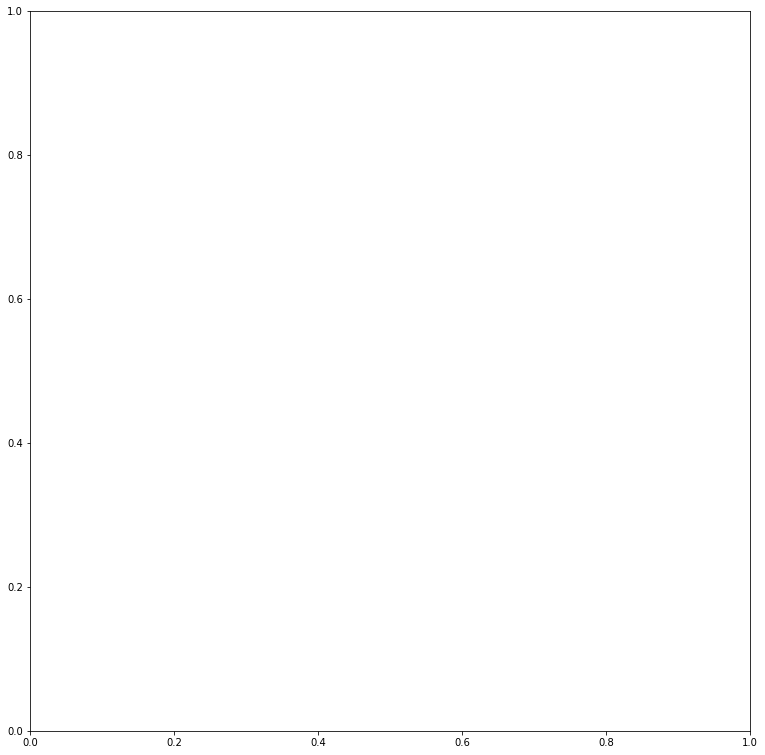

In [ ]:
nx.draw(strong_G, node_size=20, edge_color='gray')

Visualising the whole graph, but only those links of weights above a certain cutoff, allows us to get a feel for a good cutoff level to use when visualising the structure. Having filtered out these lower-weighted links, we can clean up the graph by removing the isolates. This will enable the layout engine to show us more of the structure of the components.

In [ ]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

We can also tweak the layout algorithm. By, for example, changing the ideal distance at which the repulsive and attractive forces are in equilibrium. There's a good description of these forces [here](https://schneide.blog/tag/fruchterman-reingold/). This value interacts with the number of `iterations` in surprising ways.

In [ ]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')

AttributeError: ignored

Of course, we can specify the layout we want to use, change colours, sizes, etc. The following cell adds the text of the tweets - which can make the layout hard to read.

In [ ]:
plt.rcParams['figure.figsize'] = [12,8]  # a better aspect ratio for labelled nodes

_ = nx.draw(strong_G, pos, font_size=3, node_size=50, edge_color='gray', with_labels=False)
for p in pos:  # raise positions of the labels, relative to the nodes
  pos[p][1] -= 0.03
_ = nx.draw_networkx_labels(strong_G, pos, font_size=8, font_color='k')

plt.show();

In [ ]:
dir(nx)

In [ ]:
filtered_df = nx.to_pandas_dataframe(strong_G)
filtered_df.head()

AttributeError: ignored

In [ ]:
filtered_df.to_csv('tweets_filtered.csv')

## Next Steps

I hope this notebook was useful. Next:
* I'd like to apply some keyword extraction to the tweets, to make this visualisation more useful;
* there'll be some topic identification using gensim's implementation of LDA;
* some more intelligent parameterisation of variables, such as allowing the minimum similarity cut-off to account for network size;
* I'd like to apply a smarter similarity cut-off, such as Vladimir Batagelj's '[vertex islands](http://vlado.fmf.uni-lj.si/pub/networks/doc/mix/islands.pdf)' technique; and
* I should really apply TF-IDF, if only just to see how it compares to other keyword extraction techniques.

# Metrics of Centrality

In [ ]:
strong_G.nodes

NodeView((12, 20, 31, 33, 38, 40, 42, 45, 50, 52, 53, 66, 70, 78, 81, 84, 86, 94, 95, 105, 124, 125, 127, 132, 137, 144, 146, 148, 149, 150, 152, 153, 157, 163, 169, 171, 176, 185, 187, 191, 194, 198, 210, 218, 224, 226, 231, 238, 242, 247, 252, 255, 267, 270, 278, 285, 294, 300, 302, 307, 308, 312, 315, 316, 319, 326, 328, 329, 339, 342, 345, 347, 349, 352, 356, 359, 366, 370, 385, 396, 397, 404, 406, 408, 429, 433, 441, 455, 459, 460, 461, 462, 463, 464, 467, 475, 477, 481, 482, 483, 485, 495, 501, 502, 509, 512, 516, 524, 533, 537, 540, 542, 544, 545, 555, 556, 559, 563, 585, 586, 592, 593, 602, 605, 611, 612, 614, 619, 622, 625, 627, 631, 634, 635, 637, 643, 652, 656, 658, 659, 660, 665, 668, 670, 692, 695, 696, 697, 704, 713, 717, 724, 725, 726, 728, 730, 738, 739, 748, 749, 754, 757, 761, 762, 775, 776, 786, 789, 796, 798, 799, 803, 809, 814, 818, 837, 843, 844, 859, 883, 891, 892, 896, 902, 904, 919, 922, 933, 944, 950, 953, 956, 958, 963, 964, 972, 975, 976, 981, 982, 986, 989,

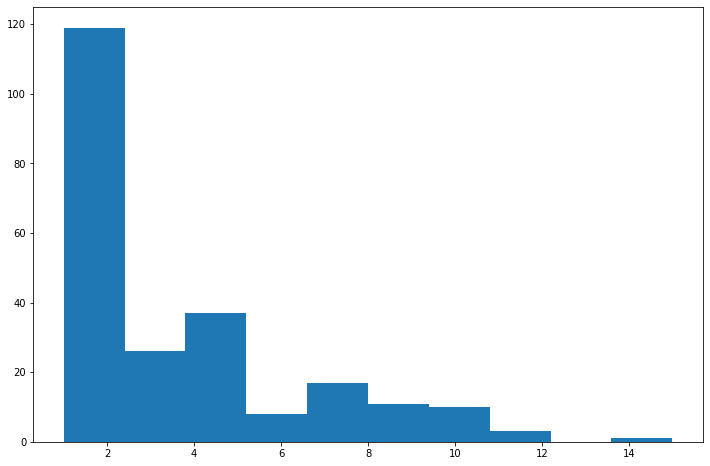

In [ ]:
#Degree plot for undirected and unweighted graph
degrees = [strong_G.degree(n) for n in strong_G.nodes()]
plt.hist(degrees);

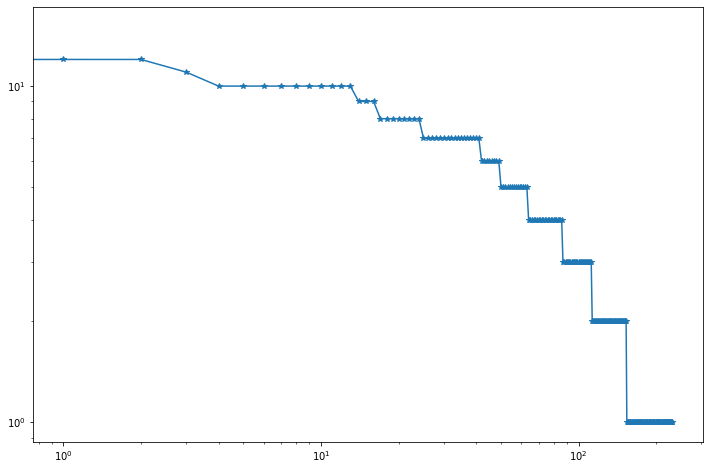

In [ ]:
degree_sequence = sorted([d for n, d in strong_G.degree()], reverse=True)
plt.loglog(degree_sequence,marker='*')
plt.show();

In [ ]:
len([d for n, d in strong_G.degree()])

232

In [ ]:
degree_sequence


[15,
 12,
 12,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
#Degree centrality for unweighted graph
degree_centrality = nx.degree_centrality(strong_G)
degree_centrality

{@rhemrajani9 @elonmusk @DavidSacks @JLinWins @BlueMoonTrades @WholeMarsBlog @MomAngtrades @DisruptorStocks @RinainDC @valueandtime @EvasTeslaSPlaid @Barchart @jasondebolt Dealings with Ukraine and China is not immediately a bad thing. People were pretty shocked about the tiktok thing (and so far republicans also haven't done shit to fix it) and also no one that isn't elons fucktoy is happy about his acquisition of Twitter.: 0.004329004329004329,
 @DavidAFrench I guess @Apple was perfectly fine with all the child porn that on twitter before the acquisition. Nope gotta draw the line at speech they don't agree with on a marketplace they control. If only jailbreaking a device to access other app markets didnt void intellectual property...: 0.012987012987012988,
 '@mehdirhasan @JeremyL38692214 Well: 0.017316017316017316,
 @tweetd99 @NONONOEU @elonmusk It's interesting that every single person who has been wailing and gnashing their teeth over Musk's acquisition of Twitter comes from the sa

In [ ]:
#Sort for identifying most inflential nodes using degree centrality
for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
  print(node, degree_centrality[node])

'@teardowntitan Sounds like you are happy with Elon’s acquisition of Twitter.  What I don’t like is Elon put himself in a position to be forced to overpay for Twitter.  It has had a negative impact on the share price.  And his tweeting has always caused him problems 0.06493506493506493
@HapcheVDushata The fact that Apple flipped so quickly after Musk's acquisition goes to show that they were here only to promote their agenda. I hope the other mega-corporations will now show their true colors too, even if that means having to work my way around installing Twitter on Android. 0.05194805194805195
@AdeyDebra @DavidPOLeary I'm no Elon defender. I'm trying to make sense of Twitter post-acquisition. But, in fairness, he claims to have Asperger syndrome. Assuming that's true, might that have some effect on his impulse control?\n\n(I could Google this but assume it's more complex than a quick search.) 0.05194805194805195
@elonmusk All that money you spent on the acquisition of Twitter you could

In [ ]:
#visualization
nx.draw_networkx(strong_G)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12300 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12301 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f15c9028560> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 864x576 with 1 Axes>

## 1.2. Closeness centrality

In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes.

In [ ]:
#Undirected and unweigted graph
closeness_centrality = nx.closeness_centrality(strong_G)

In [ ]:
#Sort for identifying most inflential nodes using closeness_centrality
for node in sorted(closeness_centrality, key=closeness_centrality.get, reverse=True):
  print(node, closeness_centrality[node])

'@teardowntitan Sounds like you are happy with Elon’s acquisition of Twitter.  What I don’t like is Elon put himself in a position to be forced to overpay for Twitter.  It has had a negative impact on the share price.  And his tweeting has always caused him problems 0.15169552669552672
@AdeyDebra @DavidPOLeary I'm no Elon defender. I'm trying to make sense of Twitter post-acquisition. But, in fairness, he claims to have Asperger syndrome. Assuming that's true, might that have some effect on his impulse control?\n\n(I could Google this but assume it's more complex than a quick search.) 0.1475956475956476
'@elonmusk Because\n\n“Racist language and misinformation have reportedly surged on Twitter since Musk’s acquisition”\n\nAnd a majority of humans don’t want to be around that shit in real life. What the fuck makes you think we want to be around it online?' 0.14371155160628846
This seems like a bad play for Musk. I know no group that has more brand allegiance than Apple users. If he is t

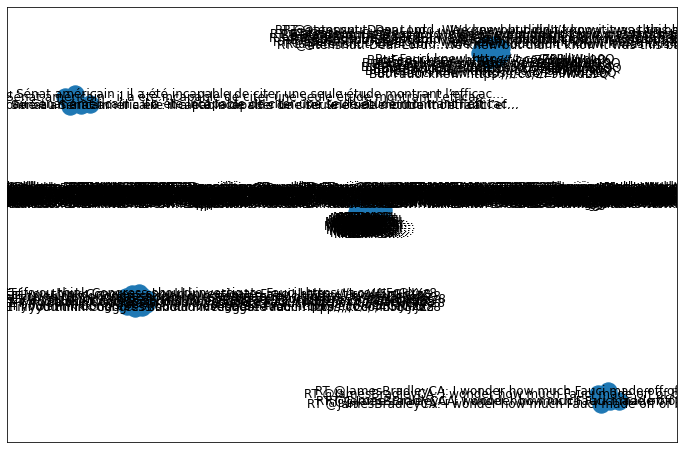

In [ ]:
nx.draw_networkx(strong_G)

In [ ]:
#Undirected and weighted
G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in strong_G.edges(data='weight')}
nx.set_edge_attributes(strong_G, G_distance_dict, 'distance')

In [ ]:
nx.closeness_centrality(strong_G, distance='distance')

{RT @atensnut: Dear Lord….We knew but didn’t know it was this bad.  
 
 But Fauci knew. https://t.co/ZP9llWdL9Q: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...
 
 MEDIA SI…: 0.5844155844155844,
 RT @f_philippot: Le 23 novembre #Fauci a été auditionné au Sénat américain : il a été incapable de citer une seule étude montrant l’efficac…: 0.05171350012124323,
 RT @JudicialWatch: RETWEET if you think Congress should investigate Fauci! https://t.co/4I5rGlJXz8: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...
 
 MEDIA SI…: 0.5844155844155844,
 RT @atensnut: Dear Lord….We knew but didn’t know it was this bad.  
 
 But Fauci knew. https://t.co/ZP9llWdL9Q: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Again

In [ ]:
# nx.draw_networkx(strong_G, width=edges['weight']/10)

## 1.2. Closeness centrality

In a connected graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes.

In [ ]:
#Undirected and unweigted graph
closeness_centrality = nx.closeness_centrality(strong_G)

In [ ]:
#Sort for identifying most inflential nodes using closeness_centrality
for node in sorted(closeness_centrality, key=closeness_centrality.get, reverse=True):
  print(node, closeness_centrality[node])

RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...

MEDIA SI… 0.5844155844155844
RT @ChuckCallesto: BREAKING REPORT: Depo

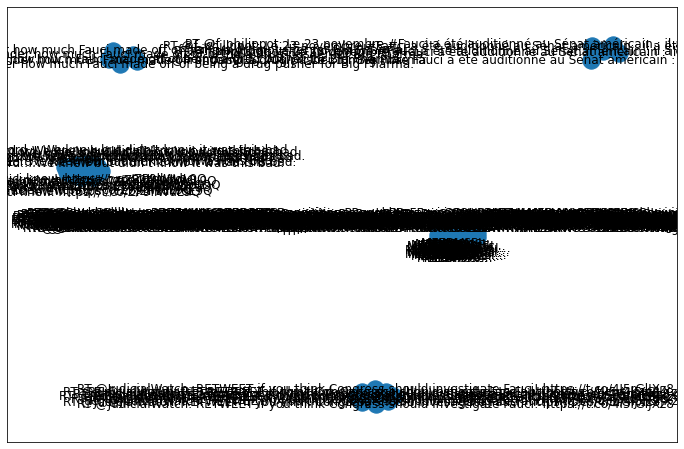

In [ ]:
nx.draw_networkx(strong_G)

In [ ]:
#Undirected and weighted
G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in strong_G.edges(data='weight')}
nx.set_edge_attributes(strong_G, G_distance_dict, 'distance')

In [ ]:
nx.closeness_centrality(strong_G, distance='distance')

{RT @atensnut: Dear Lord….We knew but didn’t know it was this bad.  
 
 But Fauci knew. https://t.co/ZP9llWdL9Q: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...
 
 MEDIA SI…: 0.5844155844155844,
 RT @f_philippot: Le 23 novembre #Fauci a été auditionné au Sénat américain : il a été incapable de citer une seule étude montrant l’efficac…: 0.05171350012124323,
 RT @JudicialWatch: RETWEET if you think Congress should investigate Fauci! https://t.co/4I5rGlJXz8: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Against COVID-19...
 
 MEDIA SI…: 0.5844155844155844,
 RT @atensnut: Dear Lord….We knew but didn’t know it was this bad.  
 
 But Fauci knew. https://t.co/ZP9llWdL9Q: 0.12987012987012986,
 RT @ChuckCallesto: BREAKING REPORT: Depositions Reveal Dr. Fauci COULDN'T NAME ANY STUDIES Showing Masks Work Again

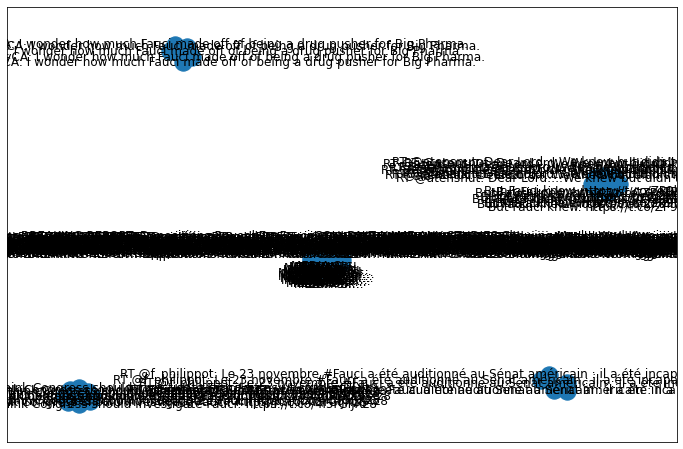

In [ ]:
nx.draw_networkx(strong_G) # , width=edges['weight']/10)

In [ ]:
#Plotted with edge width and node size
# size = [4**val for val in nx.closeness_centrality(strong_G, distance='distance').values()]
# nx.draw_networkx(strong_G, width=edges['weight']/10, node_size=size)